In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, Input

print(tf.__version__)

2.8.2


In [4]:
archive_dir = 'drive/MyDrive/Audio/Cat vs Dog/archive/'

dataframe = pd.read_csv(archive_dir+'train_test_split.csv')

dataframe.head()

,Unnamed: 0,test_cat,test_dog,train_cat,train_dog
0,0,cat_22.wav,dog_barking_97.wav,cat_99.wav,dog_barking_33.wav
1,1,cat_116.wav,dog_barking_0.wav,cat_54.wav,dog_barking_86.wav
2,2,cat_155.wav,dog_barking_93.wav,cat_34.wav,dog_barking_45.wav
3,3,cat_58.wav,dog_barking_10.wav,cat_132.wav,dog_barking_76.wav
4,4,cat_77.wav,dog_barking_26.wav,cat_124.wav,dog_barking_4.wav


In [5]:
dog_train_path = os.path.join(archive_dir, 'cats_dogs/train/dog')
cat_train_path = os.path.join(archive_dir, 'cats_dogs/train/cat')

dog_test_path = os.path.join(archive_dir, 'cats_dogs/test/dog')
cat_test_path = os.path.join(archive_dir, 'cats_dogs/test/cat')

In [ ]:
train_dog = dataframe[['train_dog']].dropna().rename(index=str, columns={"train_dog": "file"}).assign(label=1)
train_dog

In [7]:
train_cat = dataframe[['train_cat']].dropna().rename(index=str, columns={"train_cat": "file"}).assign(label=0)

In [8]:
test_dog = dataframe[["test_dog"]].dropna().rename(index=str, columns={"test_dog":"file"}).assign(label=1)

In [9]:
test_cat = dataframe[["test_cat"]].dropna().rename(index=str, columns={"test_cat": "file"}).assign(label=0)

In [10]:
train_df = pd.concat([train_dog, train_cat]).reset_index(drop=True)

In [12]:
test_df = pd.concat([test_dog, test_cat]).reset_index(drop = True)

In [14]:
train_df.head(300)

,file,label
0,dog_barking_33.wav,1
1,dog_barking_86.wav,1
2,dog_barking_45.wav,1
3,dog_barking_76.wav,1
4,dog_barking_4.wav,1
...,...,...
174,cat_15.wav,0
175,cat_88.wav,0
176,cat_73.wav,0
177,cat_32.wav,0


In [18]:
path = os.path.join(dog_train_path, dataframe['train_dog'][0])
path

'drive/MyDrive/Audio/Cat vs Dog/archive/cats_dogs/train/dog/dog_barking_33.wav'

In [22]:
from IPython.display import Audio
Audio(path)

In [24]:
!pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [45]:
from pydub import AudioSegment

wav_file = AudioSegment.from_file(file=path, format='wav')
print("Data Type %s"%type(wav_file))
print("Frame Rate: %s kHz"% str(int(wav_file.frame_rate) / 1000))
print("Channels: %s"% wav_file.channels)
print("No. of bytes per sample %s bit"% str(wav_file.sample_width * 8))

print("Length %s ms"% len(wav_file))
print("Max Amplitude %d"%wav_file.max)
print("Loudness dBFS: %.2f dB"%wav_file.dBFS)
print("Loudness max dBFS: %.2f dB"%wav_file.max_dBFS)
print("Loudness RMS %d"% wav_file.rms)

samples = np.array(wav_file.get_array_of_samples())
print(samples)

Data Type <class 'pydub.audio_segment.AudioSegment'>
Frame Rate: 16.0 kHz
Channels: 1
No. of bytes per sample 16 bit
Length 3863 ms
Max Amplitude 32736
Loudness dBFS: -20.67 dB
Loudness max dBFS: -0.01 dB
Loudness RMS 3032
[ -1   1   2 ... 114  69  13]


Sample Rate: 16000
Data Array: [ -1   1   2 ... 114  69  13]
[-3.05166468e-05  3.05166468e-05  6.10332937e-05 ...  3.47889774e-03
  2.10564863e-03  3.96716409e-04]


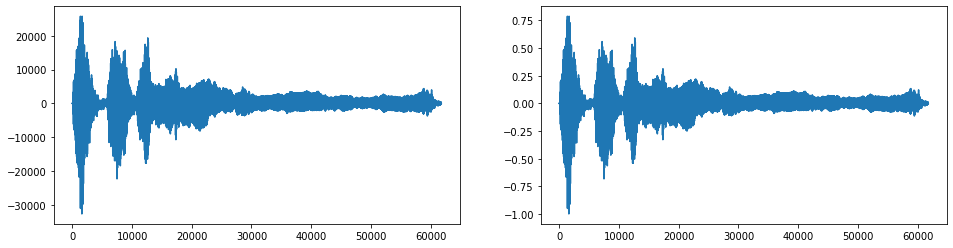

In [50]:
from scipy.io import wavfile

sample_rate, data_arr = wavfile.read(path)
print("Sample Rate: %d"% sample_rate)
print("Data Array:", data_arr)

if data_arr.dtype == 'int16':
  nb_bits = 16
elif data_arr.dtype == 'int32':
  nb_bits = 32

max_nb_bits = float(2 ** (nb_bits - 1))
samples = data_arr / (max_nb_bits + 1)
print(samples)

fix, axs = plt.subplots(1, 2, figsize=(16, 4))
axs[0].plot(data_arr)
axs[1].plot(samples)

In [52]:
import librosa

y, sr = librosa.load(path, sr = None)
print(y)
print(sr)

[-3.0517578e-05  3.0517578e-05  6.1035156e-05 ...  3.4790039e-03
  2.1057129e-03  3.9672852e-04]
16000


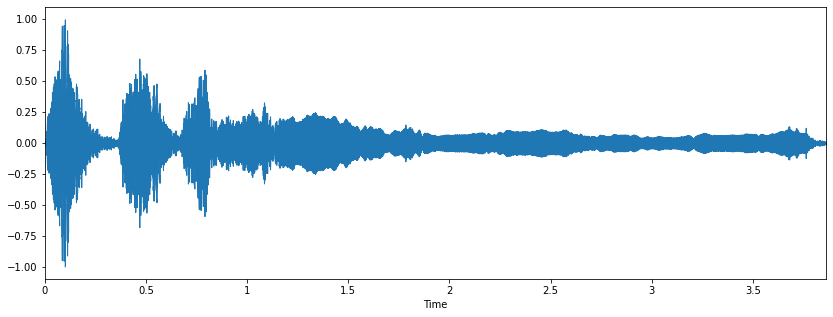

In [53]:
import librosa.display

plt.figure(figsize=(14, 5))
librosa.display.waveplot(y, sr = sr)

Create Spectrogram

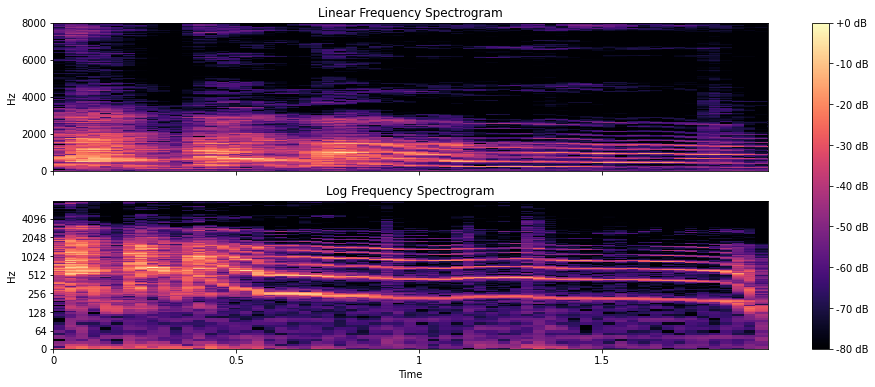

In [55]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(16, 6))
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
img = librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='hz', ax=ax[0])
ax[0].set_title("Linear Frequency Spectrogram")
ax[0].label_outer()

hop_length = 1024
D = librosa.amplitude_to_db(np.abs(librosa.stft(y, hop_length=hop_length)), ref=np.max)
librosa.display.specshow(D, sr=sr, x_axis="time", y_axis="log", ax=ax[1])
ax[1].set_title("Log Frequency Spectrogram")
ax[1].label_outer()

fig.colorbar(img, ax=ax, format="%+2.f dB")

Mel-Frequency Cepstral Coefficients (MFCCs)

(20, 121)


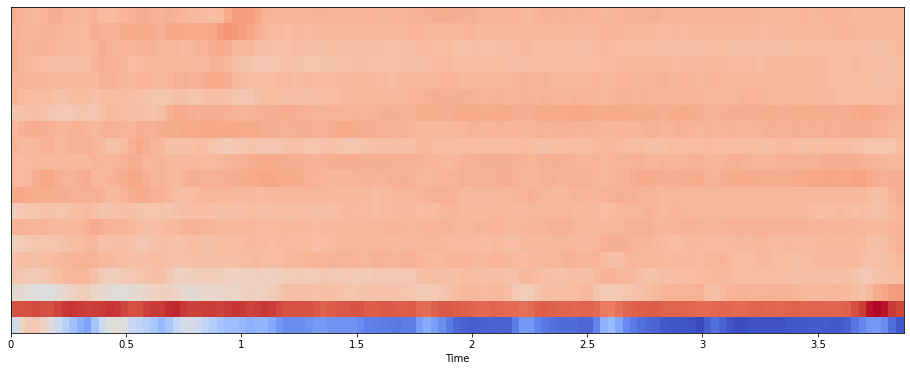

In [58]:
mfccs = librosa.feature.mfcc(y, sr=sr)
print(mfccs.shape)

plt.figure(figsize=(16, 6))
librosa.display.specshow(mfccs, sr=sr, x_axis = 'time')

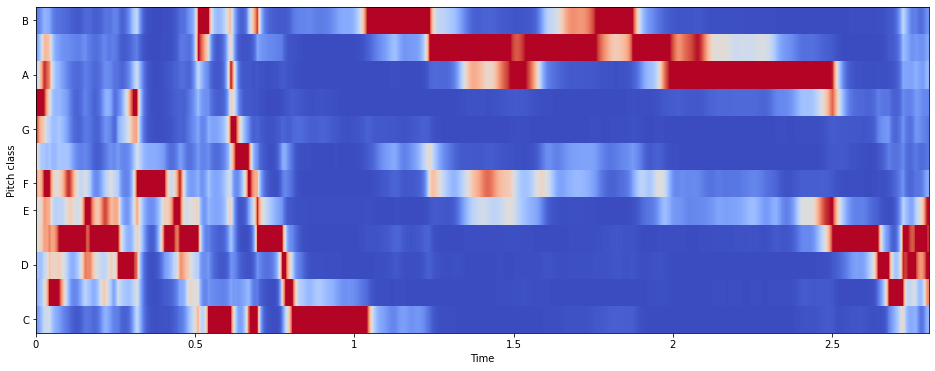

In [59]:
from librosa.feature.spectral import chroma_stft
hop_length = 12
chromagram = librosa.feature.chroma_stft(y, sr=sr, hop_length=hop_length)

plt.figure(figsize=(16, 6))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')